In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as legendre
import resource
import sys

from genquad import *
from testproblems import *
from functionfamiliy import *

In [2]:
resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

Generate test example

In [3]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = 0.1
I = Interval(1e-6,1)
F = example_problem(I, number_of_functions = 10, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()
ex_f_expr

1.04119875813792*x**4 - 0.370696923418655*x**3 - 2.5289258581704*x**2 - 1.28283818177979*x + 0.165101109889448 - 0.0833869532750961/x

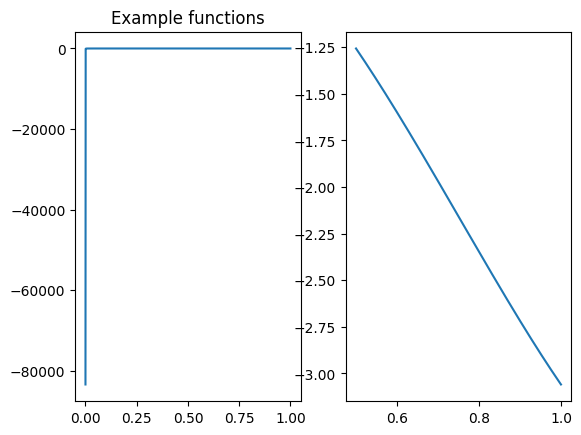

In [4]:
plt.figure("Example function")
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2)
xx2 = np.linspace((I.a+I.b)/2,I.b,1000)
plt.plot(xx2,ex_f(xx2))

Discretize and compress

In [5]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Visualise diagonal entry drop off

6


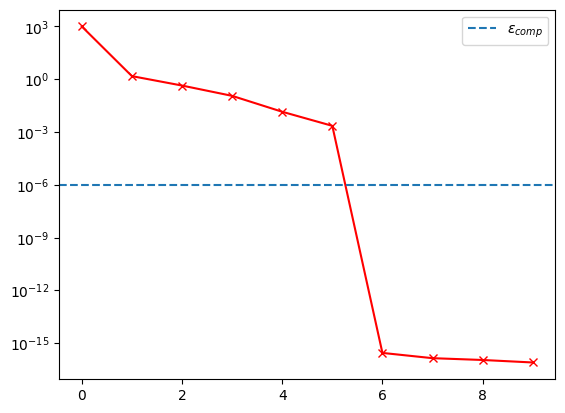

In [6]:
Q,R,perm = sp.linalg.qr(A, pivoting = True)
plt.semilogy(np.abs(np.diag(R)),"-xr");
plt.axhline(eps_comp,linestyle="--",label=r"$\varepsilon_{comp}$")
plt.legend()
print(rank)

Direction visualisation

(1e-06, 1.0)

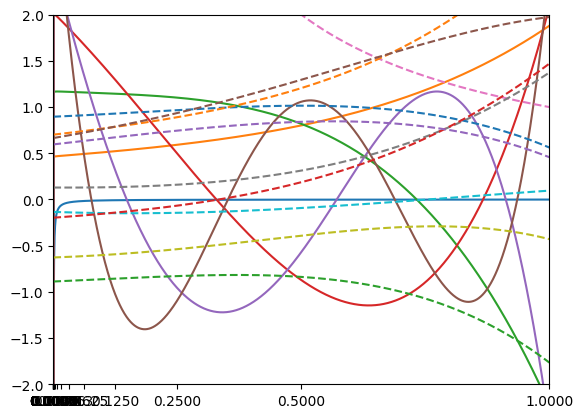

In [7]:
plt.figure();
plt.xticks(endpoints);
xx = np.linspace(I.a,I.b,2000)
for u in u_list:
    plt.plot(xx,u(xx));
for phi in F.functions:
    plt.plot(xx,phi(xx),"--");
plt.ylim(-2,2)
plt.xlim(I.a,I.b)

Chebyshev

In [8]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)
print(F.target_integral(ex_f_expr), ex_f(x_disc)@w_disc, ex_f(x_cheb)@w_cheb)

-2.35576124475336 -2.3557612447533582 -2.3557612447533525


Point comparison

[0.034 0.169 0.381 0.619 0.831 0.966]
[1.3e-06, 0.0804017, 0.3101755, 0.5988903, 0.8204309, 0.9800196]


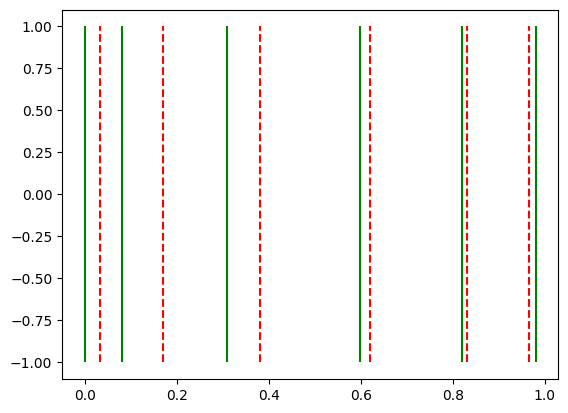

In [9]:
plt.figure()
plt.vlines(x = x_cheb, ymin=-1, ymax=1, colors = 'green',)
x_gl,_ = I.translate(np.polynomial.legendre.leggauss(rank))
plt.vlines(x = x_gl, ymin=-1, ymax=1, colors = 'red', linestyles=["dashed"])
print(np.around(x_gl,3))
print(sorted(np.around(x_cheb,7)))

Reduce number of points

In [21]:
def rank_remaining_nodes(x, w, U, J):
    n = len(x)
    
    step_directions = list()
    eta = np.zeros(n)
    for k in range(len(x)):
        Jk = J
        Jk[:,k] = 0
        Jk[:,n+k] = 0
        
        delta_r = U[k,:]*w[k] 
        delta_xk,_,_,_ = np.linalg.lstsq(Jk,delta_r,rcond=None) # Improve by using SMW
        eta[k] = np.linalg.norm(delta_xk)
        step_directions.append(delta_xk)

    idx_sorted = np.argsort(eta)
    eta = sorted(eta)
    
    return idx_sorted, step_directions, eta
        

In [22]:
def _attempt_to_remove_node(x, w, J, r, idx_sorted, step_directions, eps_quad):
    n = len(x)
    alpha = 0.1

    for k in idx_sorted:
        Jk = J
        Jk[:,k] = 0
        Jk[:,n+k] = 0
        delta_xk = step_directions[k]
        mask = np.full(n,True)
        mask[k] = False
        
        (dx,dw) = np.split(delta_xk,2)
        
        xt = x[mask] + alpha*dx[mask]
        wt = w[mask] + alpha*dw[mask]
        Ut = np.column_stack([u(xt) for u in u_list])
        eps = np.linalg.norm(Ut.T@wt - r)**2
        
        if eps < eps_quad**2:
            print(eps)
            return xt, wt, True
        
    return x, w, False
        

In [ ]:
## Attempt to use scipy.optimize

def attempt_to_remove_node(x, w, J, r, idx_sorted, step_directions, eps_quad):
    n = len(x)
    alpha = 0.1

    for k in idx_sorted:
        Jk = J
        Jk[:,k] = 0
        Jk[:,n+k] = 0
        delta_xk = step_directions[k]
        mask = np.full(n,True)
        mask[k] = False
        
        (dx,dw) = np.split(delta_xk,2)
        
        xt = x[mask] + alpha*dx[mask]
        wt = w[mask] + alpha*dw[mask]
        Ut = np.column_stack([u(xt) for u in u_list])
        eps = np.linalg.norm(Ut.T@wt - r)**2
        
        if eps < eps_quad**2:
            print(eps)
            return xt, wt, True
        
    return x, w, False

In [23]:
def point_reduction(x_cheb, w_cheb, r, u_list, eps_quad):
    r = U_disc.T@w_disc
    x = x_cheb
    w = w_cheb
    du_list = [u.deriv() for u in u_list]
    improvement_found = True

    while improvement_found:
        U = np.column_stack([u(x) for u in u_list])
        dU = np.column_stack([du(x) for du in du_list])
        J = np.hstack([dU.T*w, U.T])
        idx_sorted, step_directions, eta = rank_remaining_nodes(x, w, U, J)
        x, w, improvement_found = attempt_to_remove_node(x, w, J, r, idx_sorted, step_directions, eps_quad)

    return x, w

In [32]:
# Implement damped gauss newton with Wolfe condition.

eps_quad = 0.3
r = U_disc.T@w_disc
x,w = point_reduction(x_cheb, w_cheb, r, u_list, eps_quad)
print("Quadrature length: ", len(x))
print(F.target_integral(ex_f_expr), ex_f(x)@w)
print(r[5], u_list[5](x)@w)
print(np.linalg.norm(r))

0.08232912017396732
Quadrature length:  5
-2.35576124475336 -2.1357944980064683
-0.0004709994262672907 -0.1100333352658076
0.999999499999875
